In [108]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import optuna
from optuna.samplers import TPESampler
import pickle

In [109]:
x1=pd.read_csv('Data_Eng_Phase/DFFs/bundesliga_dff.csv')
x2=pd.read_csv('Data_Eng_Phase/DFFs/laliga_dff.csv')
x3=pd.read_csv('Data_Eng_Phase/DFFs/seria_dff.csv')
frames=[x1,x2,x3]
dff=pd.concat(frames)
#dff=x1
dff=dff.dropna()
dff=dff.reset_index(drop=True)
#dff.label=dff.label.astype('category')


X=dff.drop(['label'],axis=1)
y=dff['label']

# Split to train and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10432 entries, 0 to 10431
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AvgH                       10432 non-null  float64
 1   AvgD                       10432 non-null  float64
 2   AvgA                       10432 non-null  float64
 3   Avg>2.5                    10432 non-null  float64
 4   Avg<2.5                    10432 non-null  float64
 5   label                      10432 non-null  int64  
 6   week                       10432 non-null  int64  
 7   booking_points_home        10432 non-null  float64
 8   booking_points_away        10432 non-null  float64
 9   avg_goal_diff_home         10432 non-null  float64
 10  avg_goal_diff_away         10432 non-null  float64
 11  avg_first_half_goal_home   10432 non-null  float64
 12  avg_first_half_goal_away   10432 non-null  float64
 13  avg_second_half_goal_home  10432 non-null  flo

In [110]:
dff.label.value_counts()

1    5537
0    4895
Name: label, dtype: int64

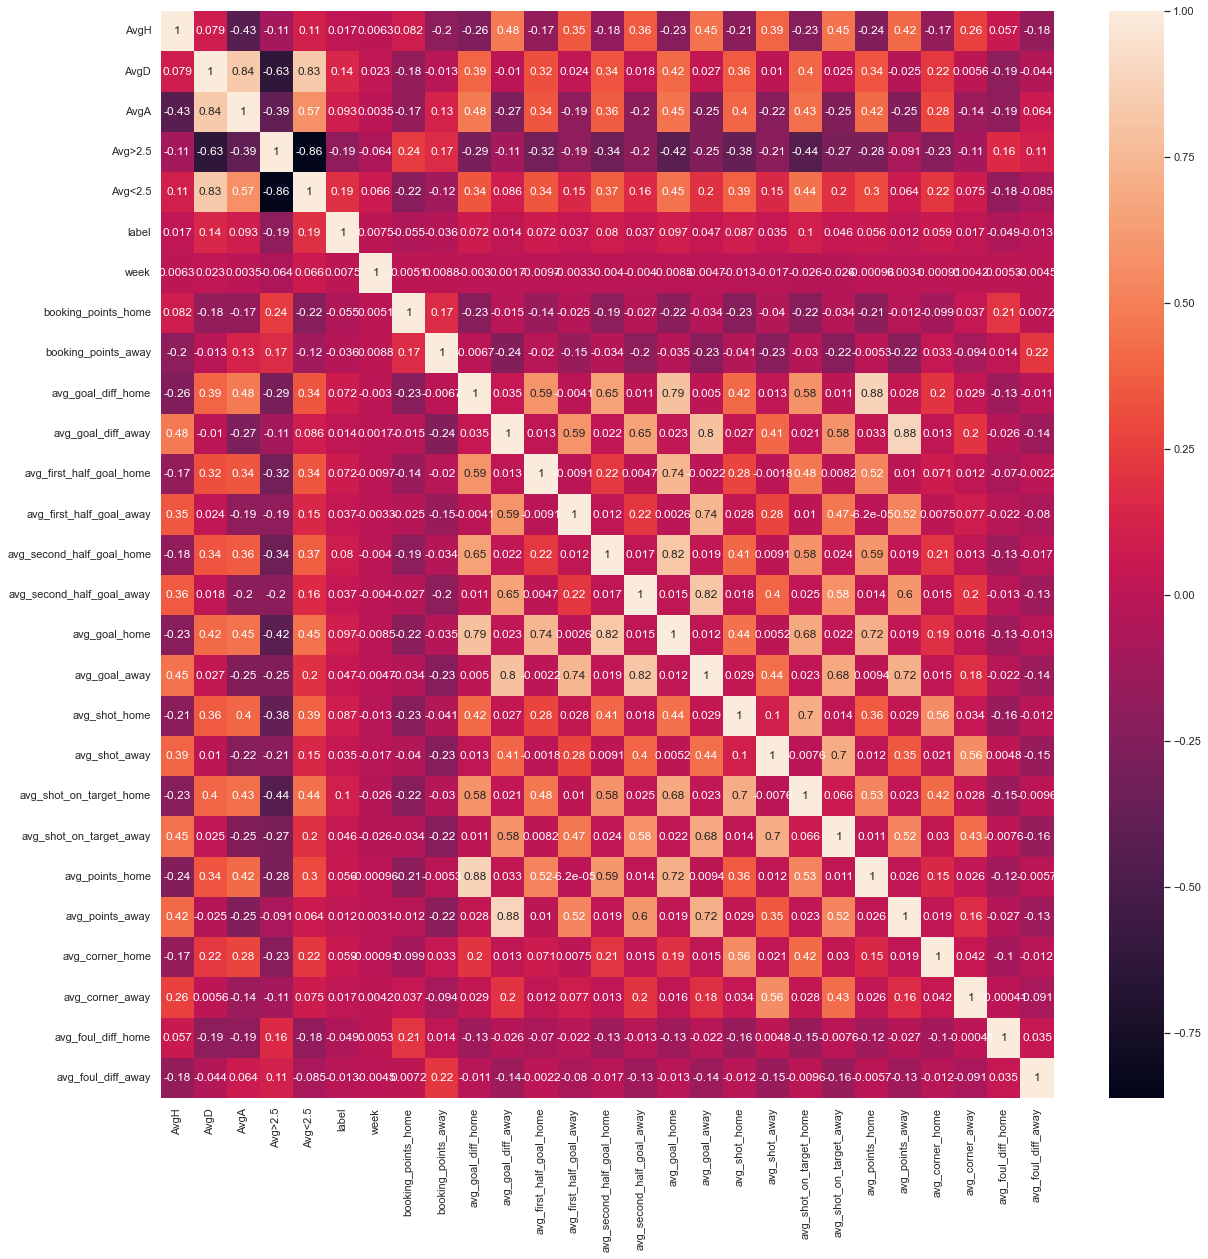

AvgH                         0.017334
AvgD                         0.142420
AvgA                         0.092635
Avg>2.5                     -0.190533
Avg<2.5                      0.190297
label                             NaN
week                         0.007473
booking_points_home         -0.054724
booking_points_away         -0.036183
avg_goal_diff_home           0.072129
avg_goal_diff_away           0.013973
avg_first_half_goal_home     0.071788
avg_first_half_goal_away     0.037345
avg_second_half_goal_home    0.080295
avg_second_half_goal_away    0.036719
avg_goal_home                0.097405
avg_goal_away                0.047311
avg_shot_home                0.087199
avg_shot_away                0.035142
avg_shot_on_target_home      0.101441
avg_shot_on_target_away      0.046381
avg_points_home              0.056330
avg_points_away              0.012312
avg_corner_home              0.059266
avg_corner_away              0.017402
avg_foul_diff_home          -0.048788
avg_foul_dif

In [113]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corr_matrix=dff.corr()
fig, ax = plt.subplots(figsize=(20,20))
sn.heatmap(corr_matrix, annot=True)
plt.show()
corr_matrix[(corr_matrix<1)].label

In [114]:
y_test.value_counts()

1    1110
0     977
Name: label, dtype: int64

In [8]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "dart",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 512),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'path_smooth':trial.suggest_uniform('path_smooth', 0.4, 1.5),
        "learning_rate": trial.suggest_float('learning_rate', 1e-4, 1e-2), 
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 80),
        'min_sum_hessian_in_leaf':trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-8, 10.0),
        'max_bin': trial.suggest_int('max_bin', 40, 500),

        }
    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

In [7]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=10)

[I 2023-09-22 21:21:49,463] A new study created in memory with name: lightgbm
C:\Users\ahmet\AppData\Local\Temp\ipykernel_24904\1909078799.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'path_smooth':trial.suggest_uniform('path_smooth', 0.4, 1.5),
C:\Users\ahmet\AppData\Local\Temp\ipykernel_24904\1909078799.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'min_sum_hessian_in_leaf':trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-8, 10.0),
[I 2023-09-22 21:21:49,518] Trial 0 finished with value: 0.522985664854177 and parameters: {'lambda_l1': 5.6649755830282306e-05, 'lambda_l2': 0.030403280126677572, 'num_leaves': 2, 'feature_fracti

[LightGBM] [Warning] feature_fraction is set=0.5813995435791038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5813995435791038
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] lambda_l1 is set=5.6649755830282306e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6649755830282306e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5.925849666609232e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5.925849666609232e-05
[LightGBM] [Warning] bagging_fraction is set=0.48805353449026784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48805353449026784
[LightGBM] [Warning] lambda_l2 is set=0.030403280126677572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030403280126677572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [

[I 2023-09-22 21:21:49,726] Trial 2 finished with value: 0.569451309935739 and parameters: {'lambda_l1': 0.7717957285411939, 'lambda_l2': 1.1257967006157268, 'num_leaves': 45, 'feature_fraction': 0.42343286993972945, 'bagging_fraction': 0.5018982517387414, 'bagging_freq': 7, 'min_child_samples': 14, 'path_smooth': 0.8632183875055575, 'learning_rate': 0.009583106348489969, 'min_data_in_leaf': 47, 'min_sum_hessian_in_leaf': 0.016861415310578325, 'max_bin': 185}. Best is trial 2 with value: 0.569451309935739.
C:\Users\ahmet\AppData\Local\Temp\ipykernel_24904\1909078799.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'path_smooth':trial.suggest_uniform('path_smooth', 0.4, 1.5),
C:\Users\ahmet\AppData\Local\Temp\ipykernel_24904\1909078799.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fea

[LightGBM] [Warning] feature_fraction is set=0.8500865889669804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8500865889669804
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] lambda_l1 is set=0.015083716080906013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015083716080906013
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.5043868475183668, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.5043868475183668
[LightGBM] [Warning] bagging_fraction is set=0.9933166533438968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9933166533438968
[LightGBM] [Warning] lambda_l2 is set=0.3248112382132015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3248112382132015
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature

[I 2023-09-22 21:21:50,016] Trial 5 finished with value: 0.5714285714285714 and parameters: {'lambda_l1': 8.337001112511277e-08, 'lambda_l2': 5.327259964195367e-05, 'num_leaves': 356, 'feature_fraction': 0.6485075617161415, 'bagging_fraction': 0.4299720753676523, 'bagging_freq': 4, 'min_child_samples': 68, 'path_smooth': 0.9663780232641395, 'learning_rate': 0.009451488084309052, 'min_data_in_leaf': 51, 'min_sum_hessian_in_leaf': 1.3508814484493448, 'max_bin': 103}. Best is trial 5 with value: 0.5714285714285714.
C:\Users\ahmet\AppData\Local\Temp\ipykernel_24904\1909078799.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'path_smooth':trial.suggest_uniform('path_smooth', 0.4, 1.5),
C:\Users\ahmet\AppData\Local\Temp\ipykernel_24904\1909078799.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Th

[LightGBM] [Warning] feature_fraction is set=0.49921251827015967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49921251827015967
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] lambda_l1 is set=1.792615409150348e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.792615409150348e-07
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.05734319754912758, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.05734319754912758
[LightGBM] [Warning] bagging_fraction is set=0.9565051482376203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9565051482376203
[LightGBM] [Warning] lambda_l2 is set=0.18472326594233746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18472326594233746
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-09-22 21:21:50,248] Trial 6 finished with value: 0.5679683638161147 and parameters: {'lambda_l1': 1.792615409150348e-07, 'lambda_l2': 0.18472326594233746, 'num_leaves': 205, 'feature_fraction': 0.49921251827015967, 'bagging_fraction': 0.9565051482376203, 'bagging_freq': 3, 'min_child_samples': 77, 'path_smooth': 1.1985977838854966, 'learning_rate': 0.008844730302937517, 'min_data_in_leaf': 54, 'min_sum_hessian_in_leaf': 0.05734319754912758, 'max_bin': 200}. Best is trial 5 with value: 0.5714285714285714.
C:\Users\ahmet\AppData\Local\Temp\ipykernel_24904\1909078799.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'path_smooth':trial.suggest_uniform('path_smooth', 0.4, 1.5),
C:\Users\ahmet\AppData\Local\Temp\ipykernel_24904\1909078799.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Th

[LightGBM] [Warning] feature_fraction is set=0.9789040282890313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9789040282890313
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] lambda_l1 is set=2.6875157982766948e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6875157982766948e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.712281485061178e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.712281485061178e-05
[LightGBM] [Warning] bagging_fraction is set=0.7980648986910688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980648986910688
[LightGBM] [Warning] lambda_l2 is set=1.1560482583788434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1560482583788434
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\ahmet\AppData\Local\Temp\ipykernel_24904\1909078799.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'path_smooth':trial.suggest_uniform('path_smooth', 0.4, 1.5),
C:\Users\ahmet\AppData\Local\Temp\ipykernel_24904\1909078799.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'min_sum_hessian_in_leaf':trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-8, 10.0),
[I 2023-09-22 21:21:50,503] Trial 8 finished with value: 0.5734058329214039 and parameters: {'lambda_l1': 1.3502546608300985, 'lambda_l2': 0.0014558458072354338, 'num_leaves': 3, 'feature_fraction': 0.7702869481724344, 'bagging_fraction': 0.5959869410632577, 'bagging_freq':

[LightGBM] [Warning] feature_fraction is set=0.7702869481724344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7702869481724344
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] lambda_l1 is set=1.3502546608300985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3502546608300985
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.3880054955129728e-08, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.3880054955129728e-08
[LightGBM] [Warning] bagging_fraction is set=0.5959869410632577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5959869410632577
[LightGBM] [Warning] lambda_l2 is set=0.0014558458072354338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014558458072354338
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warnin

In [8]:
model = lgb.LGBMClassifier(**study.best_params)
model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.7702869481724344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7702869481724344
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] lambda_l1 is set=1.3502546608300985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3502546608300985
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.3880054955129728e-08, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.3880054955129728e-08
[LightGBM] [Warning] bagging_fraction is set=0.5959869410632577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5959869410632577
[LightGBM] [Warning] lambda_l2 is set=0.0014558458072354338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014558458072354338
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


LGBMClassifier(bagging_fraction=0.5959869410632577, bagging_freq=4,
               feature_fraction=0.7702869481724344,
               lambda_l1=1.3502546608300985, lambda_l2=0.0014558458072354338,
               learning_rate=0.009094497994106013, max_bin=468,
               min_child_samples=90, min_data_in_leaf=54,
               min_sum_hessian_in_leaf=1.3880054955129728e-08, num_leaves=3,
               path_smooth=0.7929967360027498)

In [9]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)


0.5753830944142363

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.36      0.45       965
           1       0.57      0.77      0.66      1058

    accuracy                           0.58      2023
   macro avg       0.58      0.57      0.55      2023
weighted avg       0.58      0.58      0.56      2023



In [115]:
feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp.nlargest(5).plot(kind='barh', figsize=(8,10))

AttributeError: 'Sequential' object has no attribute 'feature_importances_'

In [24]:
def objective(trial):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [25]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=10)

[I 2023-04-14 22:50:17,263] A new study created in memory with name: catboost
[I 2023-04-14 22:50:18,436] Trial 0 finished with value: 0.5736866573686658 and parameters: {'iterations': 475, 'learning_rate': 0.027583475549166746, 'depth': 4, 'l2_leaf_reg': 1.0551779964424746e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 2.0931628460945333e-07, 'bagging_temperature': 0.923385947687978, 'od_type': 'Iter', 'od_wait': 26}. Best is trial 0 with value: 0.5736866573686658.
[I 2023-04-14 22:50:20,795] Trial 1 finished with value: 0.5736866573686658 and parameters: {'iterations': 585, 'learning_rate': 0.006892694481137703, 'depth': 8, 'l2_leaf_reg': 1.10795595820296e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 0.7999391045172093, 'bagging_temperature': 0.27387593197926163, 'od_type': 'IncToDec', 'od_wait': 32}. Best is trial 0 with value: 0.5736866573686658.
[I 2023-04-14 22:50:22,254] Trial 2 finished with value: 0.5695025569502556 and parameters: {'iterations': 226, 'learning_

In [26]:
model = catboost.CatBoostClassifier(**study.best_params)
model.fit(X_train, y_train)

0:	learn: 0.6930771	total: 3.54ms	remaining: 1.67s
1:	learn: 0.6930428	total: 6.5ms	remaining: 1.53s
2:	learn: 0.6929905	total: 9.7ms	remaining: 1.52s
3:	learn: 0.6929402	total: 12.9ms	remaining: 1.51s
4:	learn: 0.6928749	total: 16ms	remaining: 1.49s
5:	learn: 0.6928204	total: 19.1ms	remaining: 1.48s
6:	learn: 0.6927838	total: 22.2ms	remaining: 1.48s
7:	learn: 0.6927469	total: 25.3ms	remaining: 1.47s
8:	learn: 0.6926897	total: 28.4ms	remaining: 1.46s
9:	learn: 0.6926396	total: 31.5ms	remaining: 1.46s
10:	learn: 0.6926074	total: 34.6ms	remaining: 1.45s
11:	learn: 0.6925495	total: 37.8ms	remaining: 1.45s
12:	learn: 0.6925148	total: 40.9ms	remaining: 1.45s
13:	learn: 0.6924594	total: 44ms	remaining: 1.44s
14:	learn: 0.6924012	total: 47.1ms	remaining: 1.44s
15:	learn: 0.6923449	total: 50.2ms	remaining: 1.43s
16:	learn: 0.6922811	total: 53.3ms	remaining: 1.43s
17:	learn: 0.6922199	total: 56.3ms	remaining: 1.42s
18:	learn: 0.6921938	total: 59.4ms	remaining: 1.42s
19:	learn: 0.6921483	total: 

174:	learn: 0.6851497	total: 545ms	remaining: 928ms
175:	learn: 0.6851128	total: 548ms	remaining: 925ms
176:	learn: 0.6850576	total: 552ms	remaining: 923ms
177:	learn: 0.6850188	total: 555ms	remaining: 920ms
178:	learn: 0.6849835	total: 559ms	remaining: 918ms
179:	learn: 0.6849285	total: 562ms	remaining: 915ms
180:	learn: 0.6848957	total: 565ms	remaining: 912ms
181:	learn: 0.6848595	total: 568ms	remaining: 909ms
182:	learn: 0.6847997	total: 571ms	remaining: 905ms
183:	learn: 0.6847656	total: 574ms	remaining: 902ms
184:	learn: 0.6847527	total: 577ms	remaining: 899ms
185:	learn: 0.6847145	total: 580ms	remaining: 896ms
186:	learn: 0.6846845	total: 584ms	remaining: 892ms
187:	learn: 0.6846598	total: 587ms	remaining: 889ms
188:	learn: 0.6846067	total: 590ms	remaining: 886ms
189:	learn: 0.6845520	total: 593ms	remaining: 883ms
190:	learn: 0.6845099	total: 596ms	remaining: 880ms
191:	learn: 0.6844527	total: 599ms	remaining: 877ms
192:	learn: 0.6844044	total: 602ms	remaining: 873ms
193:	learn: 

348:	learn: 0.6785650	total: 1.09s	remaining: 386ms
349:	learn: 0.6785150	total: 1.09s	remaining: 383ms
350:	learn: 0.6784766	total: 1.09s	remaining: 380ms
351:	learn: 0.6784433	total: 1.1s	remaining: 377ms
352:	learn: 0.6784059	total: 1.1s	remaining: 374ms
353:	learn: 0.6783779	total: 1.1s	remaining: 371ms
354:	learn: 0.6783306	total: 1.11s	remaining: 368ms
355:	learn: 0.6783001	total: 1.11s	remaining: 365ms
356:	learn: 0.6782500	total: 1.11s	remaining: 362ms
357:	learn: 0.6781997	total: 1.12s	remaining: 359ms
358:	learn: 0.6781838	total: 1.12s	remaining: 356ms
359:	learn: 0.6781400	total: 1.12s	remaining: 352ms
360:	learn: 0.6780977	total: 1.13s	remaining: 349ms
361:	learn: 0.6780584	total: 1.13s	remaining: 346ms
362:	learn: 0.6780289	total: 1.13s	remaining: 343ms
363:	learn: 0.6779871	total: 1.13s	remaining: 340ms
364:	learn: 0.6779434	total: 1.14s	remaining: 337ms
365:	learn: 0.6778997	total: 1.14s	remaining: 334ms
366:	learn: 0.6778786	total: 1.14s	remaining: 330ms
367:	learn: 0.6

In [27]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.5746164574616457

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.46      0.50       989
           1       0.59      0.67      0.63      1162

    accuracy                           0.57      2151
   macro avg       0.57      0.57      0.56      2151
weighted avg       0.57      0.57      0.57      2151



<AxesSubplot:>

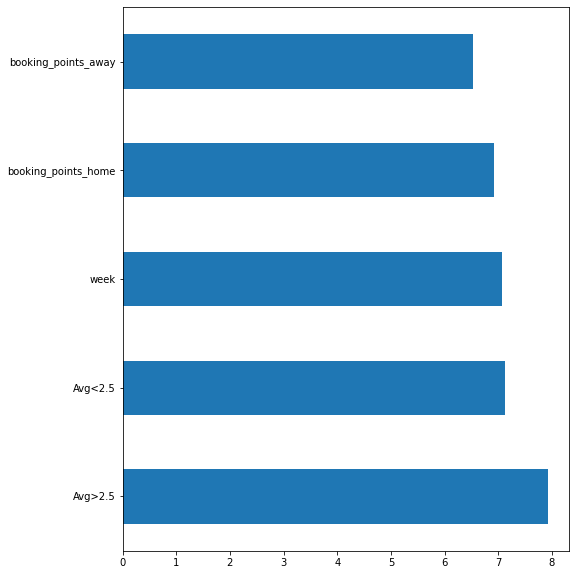

In [29]:
feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp.nlargest(5).plot(kind='barh', figsize=(8,10))

In [117]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7999844190658640523
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5734662144
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15042284757878344976
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [118]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [119]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [123]:
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.constraints import MaxNorm


#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

#def create_model():
model = Sequential() 
model.add(Dense(16 ,kernel_initializer='normal',kernel_constraint=MaxNorm(5.0) ,kernel_regularizer=regularizers.l2(0.009), activation='softsign' , input_dim=26))
model.add(Dropout(0.5))
model.add(Dense(8 ,kernel_initializer='normal',kernel_constraint=MaxNorm(5.0) ,kernel_regularizer=regularizers.l2(0.009), activation='softsign' , input_dim=26))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) 
opt = RMSprop(learning_rate=0.001, momentum=0.4)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 
model.summary()
#return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                432       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 8)                 136       
                                                                 
 dropout_9 (Dropout)         (None, 8)                 0         
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [124]:
X=dff.drop(['label'],axis=1)
y=dff['label']
ss = StandardScaler()
X=ss.fit_transform(X)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)



In [125]:
tf.debugging.set_log_device_placement(True)
with tf.device('/device:GPU:0'):    
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=16)

Epoch 1/10
587/587 [==============================] - 3s 4ms/step - loss: 0.6874 - accuracy: 0.5582 - val_loss: 0.6831 - val_accuracy: 0.5651
Epoch 2/10
587/587 [==============================] - 2s 3ms/step - loss: 0.6834 - accuracy: 0.5700 - val_loss: 0.6839 - val_accuracy: 0.5536
Epoch 3/10
587/587 [==============================] - 2s 3ms/step - loss: 0.6826 - accuracy: 0.5684 - val_loss: 0.6787 - val_accuracy: 0.5670
Epoch 4/10
587/587 [==============================] - 2s 3ms/step - loss: 0.6826 - accuracy: 0.5667 - val_loss: 0.6816 - val_accuracy: 0.5441
Epoch 5/10
587/587 [==============================] - 2s 3ms/step - loss: 0.6822 - accuracy: 0.5690 - val_loss: 0.6773 - val_accuracy: 0.5536
Epoch 6/10
587/587 [==============================] - 2s 3ms/step - loss: 0.6826 - accuracy: 0.5673 - val_loss: 0.6810 - val_accuracy: 0.5421
Epoch 7/10
587/587 [==============================] - 2s 3ms/step - loss: 0.6817 - accuracy: 0.5691 - val_loss: 0.6784 - val_accuracy: 0.5805
Epoch 

[]

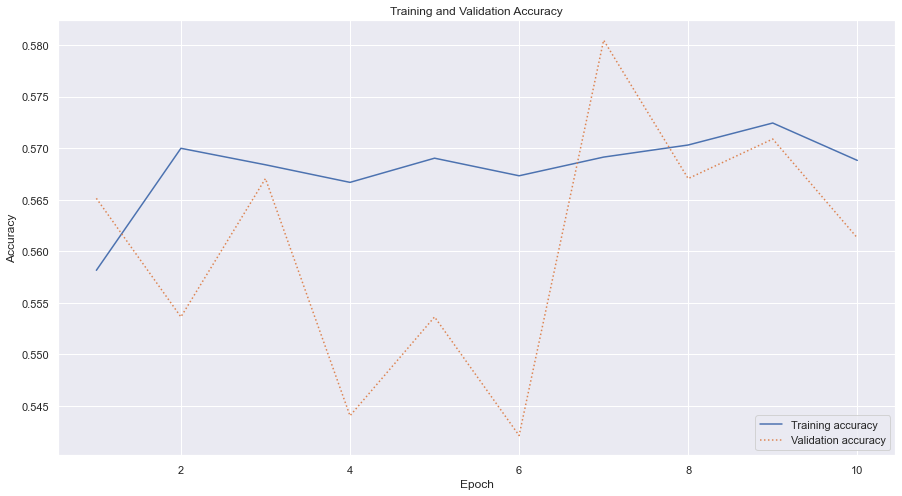

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(15,8))

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

[]

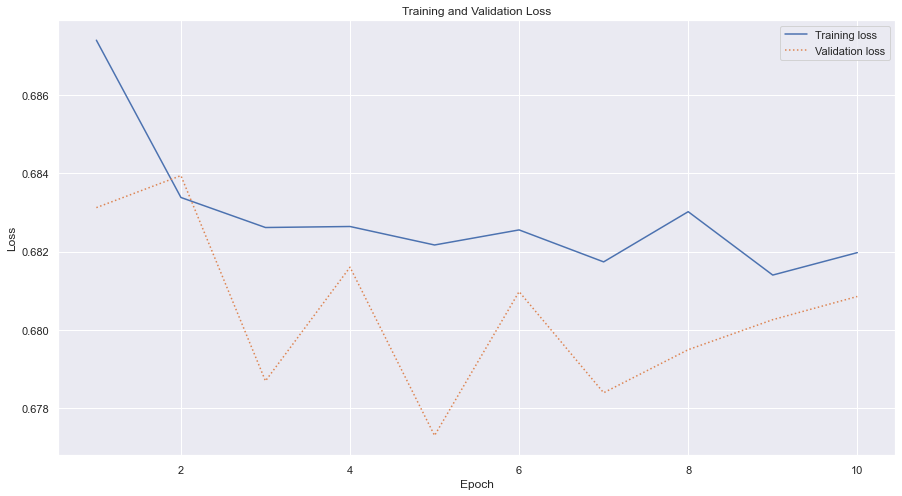

In [127]:
sns.set()
acc = hist.history['loss']
val = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,8))
plt.plot(epochs, acc, '-', label='Training loss')
plt.plot(epochs, val, ':', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.plot()

0.5862068965517241

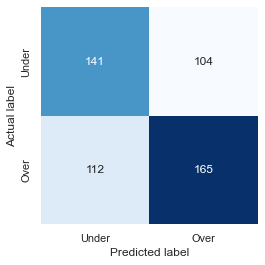

In [137]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(X_test) > 0.55
mat = confusion_matrix(y_test, y_predicted)
labels = ['Under', 'Over']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')
accuracy_score(y_test, y_predicted)

In [138]:
model.save('Model_Pickle')

INFO:tensorflow:Assets written to: Model_Pickle\assets


In [30]:
## NEURON NUMBER SEARCH: 16 and half after every layer ##

seed = 7
tf.random.set_seed(seed)
# create model
model = KerasClassifier(model=create_model, epochs=50, batch_size=128, verbose=0)
# define the grid search parameters
neurons = [2, 4, 8, 16, 32]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.576311 using {'model__neurons': 16}
0.573173 (0.008498) with: {'model__neurons': 2}
0.571081 (0.007064) with: {'model__neurons': 4}
0.573987 (0.007919) with: {'model__neurons': 8}
0.576311 (0.006393) with: {'model__neurons': 16}
0.575149 (0.006688) with: {'model__neurons': 32}


In [24]:
## DROPOUT AND WEIGHT SEARCH: dropoout:0.1 and weight_constraint:5.0 ##

seed = 7
tf.random.set_seed(seed)
# create model
model = KerasClassifier(model=create_model, epochs=50, batch_size=128, verbose=0)
# define the grid search parameters
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, model__weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.577009 using {'model__dropout_rate': 0.1, 'model__weight_constraint': 5.0}
0.575963 (0.005635) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 1.0}
0.575614 (0.005828) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 2.0}
0.575149 (0.005981) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 3.0}
0.575149 (0.006441) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 4.0}
0.575149 (0.006092) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 5.0}
0.575265 (0.006794) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 1.0}
0.575963 (0.006774) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 2.0}
0.575498 (0.006375) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 3.0}
0.575963 (0.007912) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 4.0}
0.577009 (0.007362) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 5.0}
0.575614 (0.008780) with: {'model__dr

In [18]:
## ACTIVATION FUNCTION SEARCH: softsign ##

seed = 7
tf.random.set_seed(seed)
# create model
model = KerasClassifier(model=create_model, epochs=50, batch_size=128, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.574103 using {'model__activation': 'softsign'}
0.529699 (0.000087) with: {'model__activation': 'softmax'}
0.529699 (0.000087) with: {'model__activation': 'softplus'}
0.574103 (0.004369) with: {'model__activation': 'softsign'}
0.570151 (0.009706) with: {'model__activation': 'relu'}
0.572708 (0.002250) with: {'model__activation': 'tanh'}
0.529699 (0.000087) with: {'model__activation': 'sigmoid'}
0.529699 (0.000087) with: {'model__activation': 'hard_sigmoid'}
0.573405 (0.002790) with: {'model__activation': 'linear'}


In [14]:
## KERNEL INIT SEARCH: init_mode: normal ##

seed = 7
tf.random.set_seed(seed)
# create model
model = KerasClassifier(model=create_model, epochs=50, batch_size=128, verbose=0)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(model__init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.573871 using {'model__init_mode': 'normal'}
0.569337 (0.009859) with: {'model__init_mode': 'uniform'}
0.568058 (0.007484) with: {'model__init_mode': 'lecun_uniform'}
0.573871 (0.007242) with: {'model__init_mode': 'normal'}
0.529699 (0.000087) with: {'model__init_mode': 'zero'}
0.572824 (0.007973) with: {'model__init_mode': 'glorot_normal'}
0.552479 (0.016381) with: {'model__init_mode': 'glorot_uniform'}
0.560620 (0.012570) with: {'model__init_mode': 'he_normal'}
0.573405 (0.007280) with: {'model__init_mode': 'he_uniform'}


In [11]:
## LEARNING RATE AND MOMENTUM SEARCH WITH 128 BS AND 50 EPOCH : LR:0.001 and Momentum:0.4 ##

seed = 7
tf.random.set_seed(seed)
# create model
model = KerasClassifier(model=create_model, loss="binary_crossentropy", optimizer="RMSprop", epochs=50, batch_size=128, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.572709 using {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.4}
0.557478 (0.012185) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.0}
0.566431 (0.008197) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.2}
0.572709 (0.013430) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.4}
0.566897 (0.009627) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}
0.546208 (0.018721) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.8}
0.529699 (0.000087) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.9}
0.529699 (0.000087) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.0}
0.529699 (0.000087) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.529699 (0.000087) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.4}
0.529699 (0.000087) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.6}
0.529699 (0.000087)

In [17]:
## OPTIMIZER SEARCH WITH 128 BS AND 50 EPOCH : RMSPROP ##

seed = 7
tf.random.set_seed(seed)
# create model
model = KerasClassifier(model=create_model, loss="binary_crossentropy", epochs=50, batch_size=128, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.566664 using {'optimizer': 'RMSprop'}
0.529466 (0.000142) with: {'optimizer': 'SGD'}
0.566664 (0.006252) with: {'optimizer': 'RMSprop'}
0.527836 (0.022026) with: {'optimizer': 'Adagrad'}
0.505174 (0.024823) with: {'optimizer': 'Adadelta'}
0.540508 (0.015489) with: {'optimizer': 'Adam'}
0.530164 (0.000619) with: {'optimizer': 'Adamax'}
0.563640 (0.006102) with: {'optimizer': 'Nadam'}


In [33]:
## BATCH SIZE AND EPOCH NUMBER SEARCH :  BATCHSIZE 32 and  EPOCH 50 ##
seed = 7
tf.random.set_seed(seed)
model = KerasClassifier(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [16, 32, 64, 96, 128, 170, 222]
epochs = [15, 30, 50, 70, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.577357 using {'batch_size': 32, 'epochs': 50}
0.572243 (0.009584) with: {'batch_size': 16, 'epochs': 15}
0.570616 (0.008543) with: {'batch_size': 16, 'epochs': 30}
0.575382 (0.006894) with: {'batch_size': 16, 'epochs': 50}
0.569570 (0.011220) with: {'batch_size': 16, 'epochs': 70}
0.571081 (0.010975) with: {'batch_size': 16, 'epochs': 100}
0.574335 (0.006133) with: {'batch_size': 32, 'epochs': 15}
0.570500 (0.009022) with: {'batch_size': 32, 'epochs': 30}
0.577357 (0.005659) with: {'batch_size': 32, 'epochs': 50}
0.573755 (0.012753) with: {'batch_size': 32, 'epochs': 70}
0.571779 (0.009241) with: {'batch_size': 32, 'epochs': 100}
0.573638 (0.005700) with: {'batch_size': 64, 'epochs': 15}
0.573406 (0.010391) with: {'batch_size': 64, 'epochs': 30}
0.573987 (0.009209) with: {'batch_size': 64, 'epochs': 50}
0.572361 (0.012480) with: {'batch_size': 64, 'epochs': 70}
0.570965 (0.009052) with: {'batch_size': 64, 'epochs': 100}
0.575381 (0.004669) with: {'batch_size': 96, 'epochs': 15}

In [91]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53       486
           1       0.58      0.57      0.58       548

    accuracy                           0.56      1034
   macro avg       0.55      0.55      0.55      1034
weighted avg       0.56      0.56      0.56      1034



In [6]:
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix

In [39]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif

X_new = SelectKBest(score_func=f_classif, k=7).fit_transform(X, y)
X_new.shape

(2871, 7)

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X_new,y,test_size=0.10,random_state=42)


In [41]:
from sklearn.feature_selection import SelectPercentile

X_new = SelectPercentile(score_func=f_classif, percentile=15).fit_transform(X, y)
X_new.shape
X_train,X_test,y_train,y_test = train_test_split(X_new,y,test_size=0.20,random_state=42)


In [42]:
X_new.shape

(2871, 4)

In [69]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, max_depth=9)
svm = LinearSVC(C=0.0001)
mnb = BernoulliNB()
lr = LogisticRegression(max_iter=1000)
evc=VotingClassifier(estimators=[('mnb',mnb),('lr',lr),('rf',rf)],voting='soft')
evc.fit(X_train, y_train)

VotingClassifier(estimators=[('mnb', BernoulliNB()),
                             ('lr', LogisticRegression(max_iter=1000)),
                             ('rf',
                              RandomForestClassifier(max_depth=9,
                                                     n_estimators=30))],
                 voting='soft')

C:\Users\ahmet\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


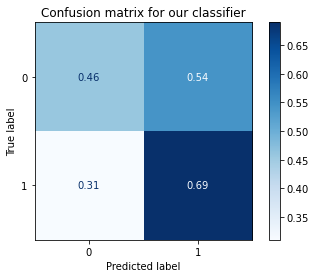

In [70]:
predictions = evc.predict(X_test)
matrix = plot_confusion_matrix(evc, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

In [71]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.57      0.46      0.51       978
           1       0.59      0.69      0.63      1089

    accuracy                           0.58      2067
   macro avg       0.58      0.57      0.57      2067
weighted avg       0.58      0.58      0.57      2067



In [72]:
print("score on test: " + str(evc.score(X_test, y_test)))
print("score on train: "+ str(evc.score(X_train, y_train)))

score on test: 0.5795839380745041
score on train: 0.6561819501572708


In [73]:
evc.predict(X_test)

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

In [74]:
y_test

7681    0
8788    0
765     0
4870    1
562     0
       ..
3055    1
2360    1
8287    1
5697    1
5146    0
Name: label, Length: 2067, dtype: int64

In [75]:
evc.predict_proba(X_test)

array([[0.52228883, 0.47771117],
       [0.30205966, 0.69794034],
       [0.48691459, 0.51308541],
       ...,
       [0.3521695 , 0.6478305 ],
       [0.55892275, 0.44107725],
       [0.57234663, 0.42765337]])

In [76]:
import pickle
# now you can save it to a file
with open('voting_classifier.pkl', 'wb') as f:
    pickle.dump(evc, f)
